In [1]:
%load_ext lab_black

# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

**Notebook objective:**
- Problem formulation
- Split out test
- Target and feature EDA
- Outlier removal on target feature
- Recommendation on data sources
- Feature engineering
- Categorical encoding


In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.m_estimate import MEstimateEncoder

from src.utils.constants import TARGET
from src.utils.funcs import get_nrf_color_group

In [4]:
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# Reading in cleaned data

In [6]:
input_path = data / "01_raw" / "src.csv"
df = pd.read_parquet(input_path)
df.shape

(60644, 11)

In [7]:
for col in [
    "PRODUCT_TYPES",
    "BUSINESS_SEGMENTS",
]:
    df[col] = df[col].astype("category")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60644 entries, 0 to 60670
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Article                60644 non-null  object  
 1   MATERIAL_CONTENT_CODE  60644 non-null  category
 2   PRODUCT_TYPES          60644 non-null  category
 3   BUSINESS_SEGMENTS      60644 non-null  category
 4   NRF_COLOR_CODE         60644 non-null  float64 
 5   MODEL                  60643 non-null  object  
 6   Sustainablity          60644 non-null  category
 7   MARKETING_CATEGORY     60644 non-null  category
 8   Units_sold             60644 non-null  int64   
 9   Searches               60644 non-null  int64   
 10  Social_References      60644 non-null  int64   
dtypes: category(5), float64(1), int64(3), object(2)
memory usage: 3.9+ MB


# Problem formulation

This demand forecasting is clearly a regression problem.

**Input data and prediction timeframes** 
<br/>The time period of unit sales of input data is not given and it is not clear that what time period is the prediction required for. Generally, very long-term forecasts are not accurate so let us assume that the given data is for first quarter of launch and we have to also predict the unit sales for first quarter of launch.

**Other model caveats**
</br>As a result of such a formulation, the model will not work in some cases:
- There is no historical article similar to the potential new (test) article
- If a black swan event like COVID-19 has occured in the test period then model will need to be adjusted 
- If there are any website display changes or changes in marketing strategy then the results of the model will not be reliable
- If there are other product launches or ongoing events in parallel on the website then the results of the model will not be reliable
- The cannibalisation effects (both on the new products, and by the new products) are not taken into account in the MVP as this is no easy task. Cannibalization is a very subtle interaction of relative pricing, inventory levels, etc.
- The model does not take into account rising and falling trends. We could have a separate trends prediction model and overlay its predictions on top of the predictions of this one

**Target** 
<br> In order to predict demand, we should directly predict units sold as that is directly actionable.
<br> We can safely ignore searches and social references for now.

**Predictors**
<br> In order to predict units sold for a new article, we can build a regression model with article attributes. Therefore, let us first remove the unnecessary columns, viz. article and model as they are ID features and should not be used in the model.

**Model evaluation**
</br> 1. Model will be evaluated on a hold out set (20% of original data given) using MAE or MAPE.
</br> 2. This model should also be compared to a baseline process or model to see if this model actually does better or not.
    </br>- The baseline process could be an analyst picking up similar articles from historic data (in terms of product attributes) and averaging their sales
    </br>- The basline model could be an algorithm picking the top most similar articles instead and then again, averaging their sales
</br> However, in interest of time, I am skipping building a baseline model.

# Keeping test data aside 

Assuming that the `MODEL` feature in the data corresponds to an actual model i.e. a bunch of articles with color variations, then a model would be a whole new product. As a result,  the train and test split should not lead to articles of the same model getting into both dataframes.

In [9]:
df = df[~df.MODEL.isna()]

In [10]:
# Creating a dataframe with model id and its count of articles.
# Later we will use this dataframe to tag models that should fall into train or test data based on 80/20 (train/test) distribution of rows
model_df = pd.DataFrame(df.MODEL.value_counts())
model_df["Model_ID"] = model_df.index
model_df = model_df.reset_index(drop=True)
model_df.head()

,MODEL,Model_ID
0,222,DVF21
1,112,DBB20
2,99,DVF22
3,94,DBB22
4,92,EPD53


In [11]:
total_rows = model_df.MODEL.sum()

# shuffle the dataframe
model_df_shuffled = model_df.sample(frac=1)

# create `split_id` column and instantiate it with all "test" values. This will be update later
model_df_shuffled["split_id"] = "test"

# This variable holds the value of count of rows in training set and will be used in the upcoming for loop
train_sum = 0

# Pick rows from the shuffled set until training set has 80% of total rows
for row in range(0, len(model_df_shuffled)):
    train_sum = train_sum + model_df_shuffled.iloc[row, 0]
    model_df_shuffled.iloc[row, 2] = "train"
    if train_sum > total_rows * 0.8:
        break

print(train_sum / df.shape[0])

0.800075853767129


In [12]:
# Use the `split_id` created above and merge it to original `df` dataframe. Use that to create our raw test and training dataframes
model_df_shuffled = model_df_shuffled[["Model_ID", "split_id"]]
df = df.merge(model_df_shuffled, left_on="MODEL", right_on="Model_ID")

train = df[df["split_id"] == "train"]
test = df[df["split_id"] == "test"]
print(train.shape, test.shape)

(48519, 13) (12124, 13)


In [13]:
# Dropping unnecessary columns from both test and train sets
test.drop(
    columns=[
        "Article",
        "MODEL",
        "Searches",
        "Social_References",
        "Model_ID",
        "split_id",
    ],
    inplace=True,
)
train.drop(
    columns=[
        "Article",
        "MODEL",
        "Searches",
        "Social_References",
        "Model_ID",
        "split_id",
    ],
    inplace=True,
)

train.head()

c:\users\igari\anaconda3\envs\brand\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold
0,TRFU,44.0000,97528.0000,1.0000,Organic materials,GK6,84
1,TRK4,252.0000,303030.0000,1.0000,Organic materials,GK24,96
2,TRK4,16.0000,9758975.0000,100.0000,PFC free,GK4,48
3,TRFP,251.0000,975534.0000,400.0000,Recycled plastic,GK16,132
4,PRIR,17.0000,9759758.0000,1.0000,Low carbon footprint,GK1,72


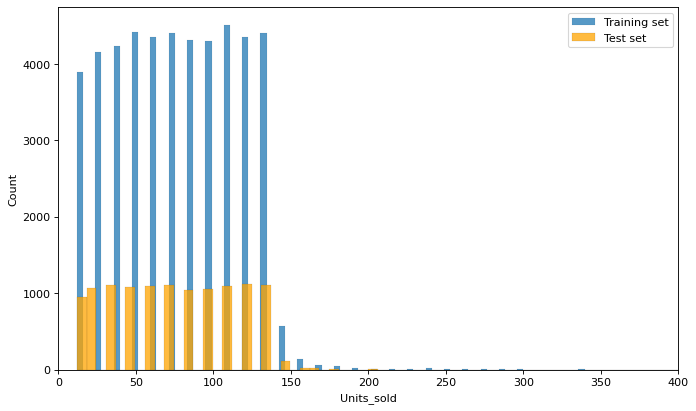

In [14]:
# Comparing the distribution of target feature in train and test dataframes
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=train, x=TARGET, label="Training set")
sns.histplot(data=test, x=TARGET, color="orange", label="Test set")
plt.xlim(0, 400)
plt.legend()
plt.show()

The two sets differ slightly in the distibution of extreme values but this can be tuned later.

In [15]:
output_test_path = data / "01_raw" / "test_raw.csv"
output_train_path = data / "01_raw" / "train_raw.csv"

test.to_parquet(output_test_path, index=None)
train.to_parquet(output_train_path, index=None)

# Exploring the target 

<AxesSubplot:xlabel='Units_sold'>

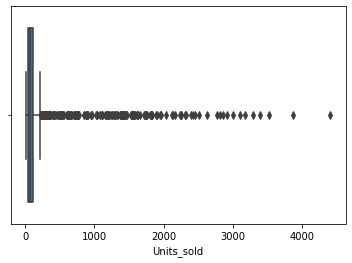

In [16]:
sns.boxplot(data=train, x=TARGET)

(0.0, 400.0)

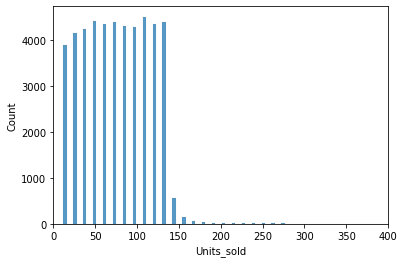

In [17]:
sns.histplot(data=train, x=TARGET)
plt.xlim(0, 400)

<AxesSubplot:xlabel='Units_sold', ylabel='Count'>

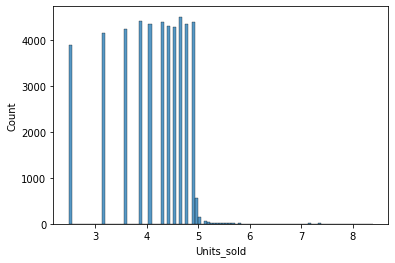

In [18]:
# What if we take a log transform?
sns.histplot(data=train, x=np.log(train[TARGET]))

The target distribution is not so normal but whether this needs to be improved, depends on the algorithm we will use. So let us leave this as a possible improvement for later.

# All of our initial features are categorical features and mostly with high cardinality. This is a challenge.

c:\users\igari\anaconda3\envs\brand\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


<AxesSubplot:xlabel='PRODUCT_TYPES', ylabel='Units_sold'>

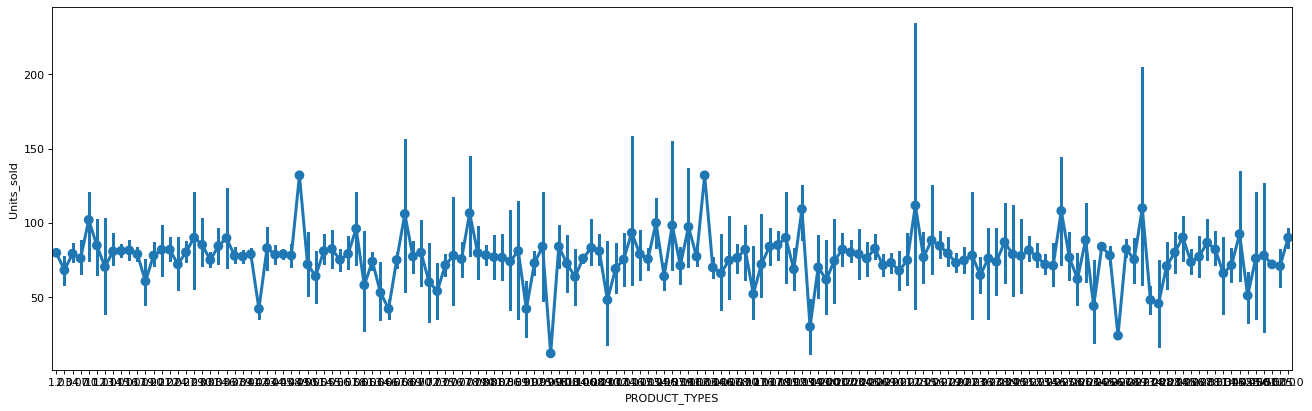

In [19]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="PRODUCT_TYPES", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='MATERIAL_CONTENT_CODE', ylabel='Units_sold'>

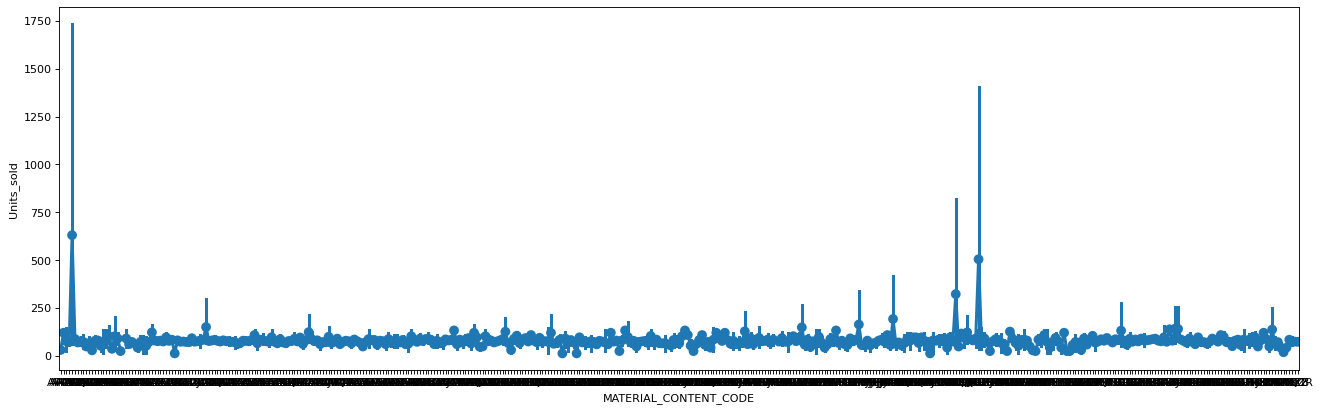

In [20]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="MATERIAL_CONTENT_CODE", y=TARGET, estimator=np.mean)

c:\users\igari\anaconda3\envs\brand\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


<AxesSubplot:xlabel='BUSINESS_SEGMENTS', ylabel='Units_sold'>

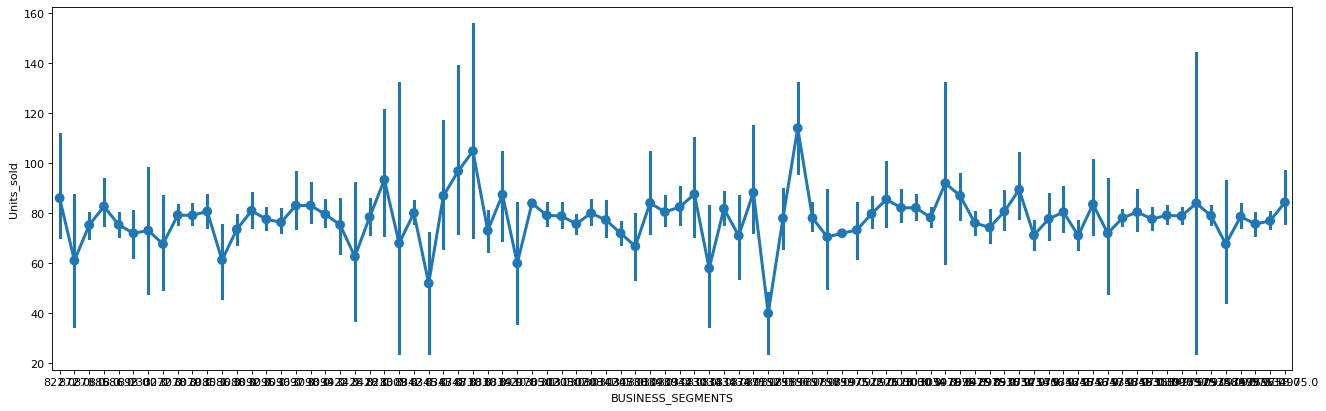

In [21]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="BUSINESS_SEGMENTS", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='NRF_COLOR_CODE', ylabel='Units_sold'>

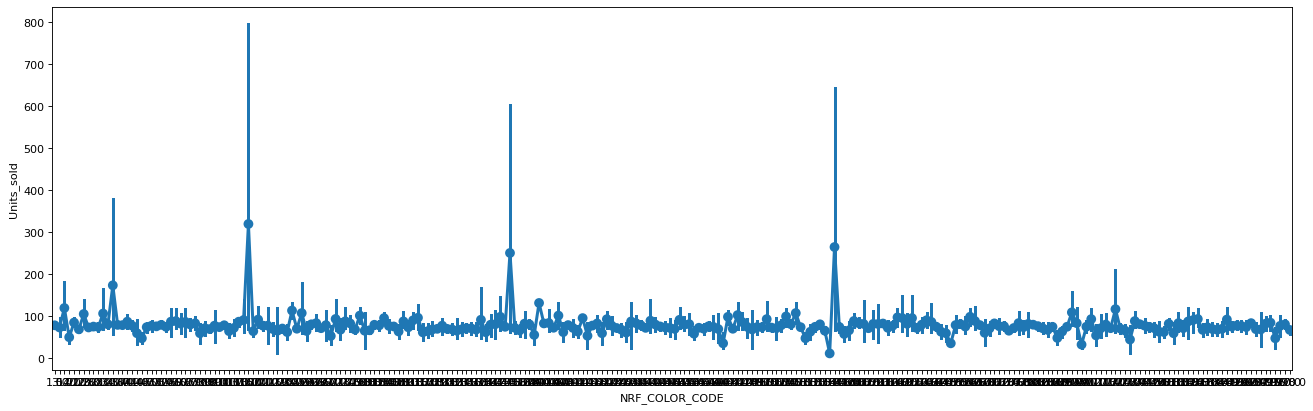

In [22]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="NRF_COLOR_CODE", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='Sustainablity', ylabel='Units_sold'>

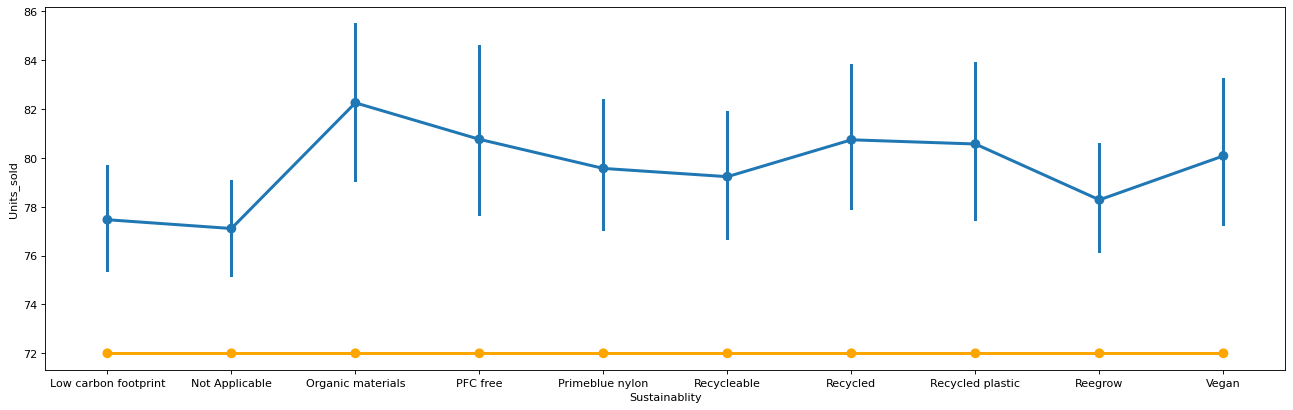

In [23]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="Sustainablity", y=TARGET, estimator=np.mean)
sns.pointplot(
    data=train, x="Sustainablity", y=TARGET, estimator=np.median, color="orange"
)

In [24]:
# plt.figure(figsize=(20, 6), dpi=80)
# sns.pointplot(data=train, x="MARKETING_CATEGORY", y=TARGET, estimator=np.mean)

All these features clearly affect the target. Also, we cannot discount the interaction effects of these features on unit sales.

# Outlier removal on target feature

<AxesSubplot:xlabel='Units_sold'>

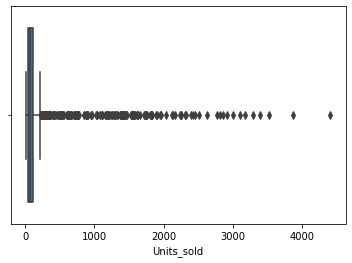

In [25]:
sns.boxplot(data=train, x="Units_sold")

In [26]:
# Check the count of outliers

Q1 = train["Units_sold"].quantile(0.25)
Q3 = train["Units_sold"].quantile(0.75)
IQR = Q3 - Q1

threshold = Q3 + 1.5 * IQR

outlier_count = (
    train["Sustainablity"][train["Units_sold"] > (Q3 + 1.5 * IQR)].count()
    / train["Sustainablity"].count()
)

print(
    f"The % of outliers in the data is {outlier_count:.2%}. This is at threshold of {threshold} "
)

The % of outliers in the data is 0.56%. This is at threshold of 216.0 


In [27]:
# It makes sense to just remove these outliers for now
train = train[train.Units_sold < threshold]
train.shape

(48230, 7)

# Recommendation of data sources

Apart from the features already given, there are many more desirable features that would improve the predictive power of this model. Some of these are:
1. Which quarter was this product launched in?
2. Did the quarter have a major holiday like Xmas or an external or internal event like Black Friday, competitor activities, etc. that might affect sales?
3. Season
4. (This year - Year) when this historic product was launched
    - This column could be used as a proxy for data recency and hence, relevancy. So this could be used to weight the training data points if the data points are too many or if this is seen to improve predictions in general.
5. More product attributes 
6. Search trends (from Google Trends). Example- Sustainability is important to consumers now, Neons are in in shoes, face mask and sunglasses chords are trending, etc.)
    - How hyped up is this trend/designer? This data can also be sourced from customer focus groups.
7. Price band of the article
8. Features around affluence level of the expected consumer demographic
9. How saturated is this product space already on the website and in terms of competition in general
    - count of similar products on website and their popularity
    - count of products (choice) within same category on website
    - Market size of this category
    - Market growth rate of this category QoQ, YoY
10. Is this a new category or color combination, etc.
    - Innovation points
    - Similarity distance from existing range in category
11. Historic sales data of similar existing products offered by Competitors
    - From consumer panel data, identified by text embeddings   
12. Product usage
    - Gift or not
    - Gender

# Feature engineering

In [28]:
# Source for NRF color groups used in the function below: http://mimage.opentext.com/alt_content/binary/businessnetwork/lids/Vendor_Catalogue_Data_Per_Macys_Guidelines.pdf

In [29]:
train["nrf_color_group"] = train.apply(get_nrf_color_group, axis=1)
train.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
0,TRFU,44.0000,97528.0000,1.0000,Organic materials,GK6,84,black
1,TRK4,252.0000,303030.0000,1.0000,Organic materials,GK24,96,black
2,TRK4,16.0000,9758975.0000,100.0000,PFC free,GK4,48,white
3,TRFP,251.0000,975534.0000,400.0000,Recycled plastic,GK16,132,blue
4,PRIR,17.0000,9759758.0000,1.0000,Low carbon footprint,GK1,72,black


In [30]:
train["nrf_color_group"].unique()

array(['black', 'white', 'blue', 'red', 'green', 'gray', 'multi',
       'yellow', 'brown', 'orange', 'beige', 'pink', 'purple', 'charcoal',
       'oxford'], dtype=object)

# Categorical encoding

In [31]:
# These are OK cardinality wise
print(train.Sustainablity.nunique(), train.nrf_color_group.nunique())

10 15


In [32]:
# Ordinal encoder is not the best but can be used as a starting point for cardinality < 20
low_cardinal_cat_cols = ["Sustainablity", "nrf_color_group"]

oe_encoder = OrdinalEncoder(cols=low_cardinal_cat_cols)

train_encoded = oe_encoder.fit_transform(train)
train_encoded.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
0,TRFU,44.0000,97528.0000,1.0000,1,GK6,84,1
1,TRK4,252.0000,303030.0000,1.0000,1,GK24,96,1
2,TRK4,16.0000,9758975.0000,100.0000,2,GK4,48,2
3,TRFP,251.0000,975534.0000,400.0000,3,GK16,132,3
4,PRIR,17.0000,9759758.0000,1.0000,4,GK1,72,1


In [33]:
# Very high cardinality features
print(
    train_encoded.MATERIAL_CONTENT_CODE.nunique(),
    train_encoded.PRODUCT_TYPES.nunique(),
    train_encoded.BUSINESS_SEGMENTS.nunique(),
    train_encoded.MARKETING_CATEGORY.nunique(),
)
# One-hot encoding or creating dummies is not an option here because of very high cardinality

431 153 84 5119


In [34]:
high_cardinal_cat_cols = [
    "MATERIAL_CONTENT_CODE",
    "PRODUCT_TYPES",
    "BUSINESS_SEGMENTS",
    "MARKETING_CATEGORY",
]

encoder = MEstimateEncoder(cols=high_cardinal_cat_cols, random_state=26, m=1.5)

train_encoded = encoder.fit_transform(train_encoded, train_encoded[TARGET])
train_encoded.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
0,74.5668,77.9072,78.2867,1.0000,1,76.1059,84,1
1,74.4568,71.5296,74.1926,1.0000,1,75.2637,96,1
2,74.4568,74.3190,73.7448,100.0000,2,78.0285,48,2
3,74.8112,75.9459,75.5553,400.0000,3,103.9623,132,3
4,58.4886,61.5648,74.1307,1.0000,4,57.5253,72,1


The value of m can be tuned in this encoder to get better model accuracy. Also, various other encoders could be tried from http://contrib.scikit-learn.org/category_encoders/index.html

The holy grail solution to categorical encoding in this case would be attribute clustering or embeddings.

In [35]:
# Save encoder object
oe_encoder_path = base_dir / "artifacts" / "oe_encoder.pkl"
file = open(oe_encoder_path, "wb")
pickle.dump(oe_encoder, file)

encoder_path = base_dir / "artifacts" / "encoder.pkl"
file = open(encoder_path, "wb")
pickle.dump(encoder, file)

In [36]:
# Save training set - overwriting
train_encoded.to_parquet(output_train_path, index=None)